## The Functions of the Discrete Voter Model

This notebook runs the following $5$ subroutines for the **discrete voter model**:
1. `make_grid`: create a probabilistic grid: an $\mathbf{R}^n$ array of values, $\omega$, that all sum to $1$
2. `shift_weight`: shift weight in a grid reversibly
3. `expec_votes`: given a grid, a candidate, and a district description, output the expectation of votes that candidate received
4. `prob_votes`: given a grid, a candidate, a district description, and the observed vote outcomes, output the probability of seeing that outcome
5. `mcmc`: run a Markov Chain Monte Carlo method on a state space of grids

`generate_random_election` generates a random election when given candidate and demographic information.

In [71]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import time
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from itertools import chain, permutations
from tqdm import trange, tqdm

sns.set(style='whitegrid')
%matplotlib inline

In [2]:
# Import written packages

import make_grid as mg
import prob_votes as pv
import expec_votes as ev
import shift_weight as sw

import kings_ei as kei
import dvm

import tools

### `make_grid`
Create a probabilistic grid: an $\mathbf{R}^n$ array of values, $\omega$, that all sum to $1$.

In [3]:
test_grid = mg.make_grid(3, 10)

In [88]:
test_grid

<tf.Tensor: shape=(10, 10, 10), dtype=float32, numpy=
array([[[1.27717256e-04, 1.14330425e-04, 1.03215664e-03, 1.05250056e-03,
         1.43593783e-03, 1.00614023e-04, 1.77452888e-03, 8.70137999e-04,
         5.01970702e-04, 9.44974308e-04],
        [7.80888600e-04, 1.93711996e-04, 1.52944424e-03, 8.77176411e-04,
         1.75369205e-03, 9.39907040e-04, 1.23851409e-03, 1.78934250e-04,
         7.69915467e-04, 1.83878257e-03],
        [1.92186621e-03, 1.32572732e-03, 7.65629695e-04, 8.52456549e-04,
         1.77434529e-03, 4.81672760e-04, 1.21878705e-03, 1.90721033e-03,
         1.03516970e-03, 3.47001420e-04],
        [7.60798517e-04, 1.68989191e-03, 8.78758146e-05, 1.66274852e-03,
         1.89241348e-03, 1.77097577e-03, 5.26814838e-04, 2.52257480e-04,
         1.31895195e-03, 1.18004810e-03],
        [7.34402041e-04, 1.64133881e-03, 1.70254277e-03, 3.61174694e-04,
         1.26910687e-03, 1.30391493e-03, 1.79491017e-03, 1.08258065e-03,
         1.89778302e-03, 9.24283988e-04],
      

### `shift_weight`
Shift weight in a grid reversibly.

In [89]:
small_test_grid = mg.make_grid(2, 3)

In [90]:
small_test_grid

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.13293481, 0.04552104, 0.03497656],
       [0.0512929 , 0.13886718, 0.08248799],
       [0.1832886 , 0.16573037, 0.1649005 ]], dtype=float32)>

In [96]:
uniform_shift_test = sw.shift_weight(small_test_grid)
print(f"grid sum: {tf.math.reduce_sum(uniform_shift_test)}")
uniform_shift_test

grid sum: 1.0


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.08316928, 0.09009208, 0.09554063],
       [0.11760984, 0.135974  , 0.16458167],
       [0.1361686 , 0.13781312, 0.0390508 ]], dtype=float32)>

In [99]:
single_uniform_shift_test = sw.shift_weight(small_test_grid, shift_type="single_uniform")
print(f"grid sum: {tf.math.reduce_sum(single_uniform_shift_test)}")
single_uniform_shift_test

grid sum: 1.0000001192092896


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.10558847, 0.09122553, 0.0914297 ],
       [0.06765476, 0.13582955, 0.14178944],
       [0.05269715, 0.10100466, 0.21278082]], dtype=float32)>

In [100]:
shuffle_shift_test = sw.shift_weight(small_test_grid, shift_type="shuffle")
print(f"grid sum: {tf.math.reduce_sum(shuffle_shift_test)}")
shuffle_shift_test

grid sum: 0.9999999403953552


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.13293481, 0.04552104, 0.03497656],
       [0.0512929 , 0.13886718, 0.08248799],
       [0.1832886 , 0.16573037, 0.1649005 ]], dtype=float32)>

In [121]:
right_shift_test = sw.shift_weight(small_test_grid, shift_type="right")
print(f"grid sum: {tf.math.reduce_sum(right_shift_test)}")
right_shift_test

<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
grid sum: 1.0


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.08573293, 0.11838567, 0.08924776],
       [0.10157007, 0.09117171, 0.12036315],
       [0.12904091, 0.13517028, 0.12931754]], dtype=float32)>

In [125]:
left_shift_test = sw.shift_weight(small_test_grid, shift_type="left")
print(f"grid sum: {tf.math.reduce_sum(left_shift_test)}")
left_shift_test

grid sum: 1.0


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0.08924776, 0.08573294, 0.11838567],
       [0.12036314, 0.10157008, 0.09117171],
       [0.12931754, 0.12904091, 0.13517028]], dtype=float32)>

### `expec_votes`
Given a grid, a candidate, and a district description, output the expectation of votes that candidate received.

In [5]:
test_demo = {"Black": 10, "white": 8, "Latinx": 5}

In [6]:
ev.expec_votes(test_grid, test_demo)

10.401940217094946

### `prob_votes`
Given a grid, a candidate, a district description, and the observed vote outcomes, output the probability of seeing that outcome.

In [7]:
test_observed = 10

In [9]:
pv.prob_votes(test_grid, test_demo, test_observed)

<tf.Tensor: shape=(), dtype=float32, numpy=0.037668765>

In [11]:
test_num_trials = 25
bounds_error_count = 0
for _ in trange(test_num_trials):
    x = pv.prob_votes(mg.make_grid(3, 10), test_demo, test_observed)
    if x > 1 or x < 0:
        bounds_error_count += 1
        print(f"Probability out of bounds at {x}")
if bounds_error_count == 0:
    print(f"No bounds errors in {test_num_trials} trials")
else:
    print(f"There were {bounds_error_count} bounds errors")

100%|██████████| 25/25 [00:14<00:00,  1.77it/s]

No bounds errors in 25 trials


### `mcmc`
Run a Markov Chain Monte Carlo method on a state space of grids.

In [215]:
import functools

In [13]:
import importlib

In [14]:
import tensorflow as tf
import tensorflow_probability as tfp

In [134]:
testy = mg.Grid(3, 10)

In [135]:
testy

Probabilistic Hypercube: shape=(10, 10, 10)

In [203]:
import election

In [15]:
# Partially apply `prob_votes`, so it only takes the grid
prob_votes_pa = functools.partial(pv.flat_prob_votes, demo=test_demo, observed=test_observed, dim=test_grid.shape)

In [162]:
prob_votes_pa2 = functools.partial(pv.prob_votes, demo=test_demo, observed=test_observed)

In [213]:
prob_votes_pa(tf.reshape(test_grid, [-1]))

AttributeError: in converted code:

    /Users/hakeemangulu/Google Drive/Academic/Senior Spring/Thesis/thesis/code/prob_votes.py:40 get_vote_probability  *
        for p, coeff in coeff_dict.items():

    AttributeError: 'int' object has no attribute 'items'


In [163]:
prob_votes_pa2(test_grid)

<tf.Tensor: shape=(), dtype=float32, numpy=0.037668765>

In [17]:
def trace_everything(_, previous_kernel_results):
    return previous_kernel_results

def trace_log_accept_ratio(_, previous_kernel_results):
    return previous_kernel_results.log_accept_ratio

In [169]:
# Initialize the Hamiltonian Monte Carlo transition kernel
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=prob_votes_pa,
    step_size=0.01,
    num_leapfrog_steps=2)

In [180]:
prob_votes_pa(tf.reshape(test_grid, [-1]))

<tf.Tensor: shape=(), dtype=float32, numpy=-3.278924>

In [182]:
p = tools.permute_integer_partition(test_observed, len(test_demo))

In [170]:
tf.exp(tf.minimum(log_accept_ration, 0.))

NameError: name 'log_accept_ration' is not defined

In [298]:
def sample_chain(kernel, n_iter, current_state, previous_kernel_results):
    return tfp.mcmc.sample_chain(
        num_results=n_iter,
        num_steps_between_results=2,
        current_state=current_state,
        previous_kernel_results=previous_kernel_results,
        kernel=kernel,
        trace_fn=trace_log_accept_ratio,
        return_final_kernel_results=True)

In [299]:
def burn_in(chain_results, burn_frac):
    num_samples = chain_results.shape[0]
    start = int(burn_frac * num_samples)
    
    begin = [start]
    size = [num_samples - start]
    
    for dim in chain_results.shape[1:]:
        begin.append(0)
        size.append(dim)
    
    return tf.slice(chain_results, begin, size)

In [311]:
importlib.reload(pv)
importlib.reload(sw)
importlib.reload(mg)
importlib.reload(ev)
importlib.reload(tools)
importlib.reload(election)

<module 'election' from '/Users/hakeemangulu/Google Drive/Academic/Senior Spring/Thesis/thesis/code/election.py'>

In [312]:
# Get the coefficients for the binomial calculations
coeff_dict = election.get_coefficients(test_demo, test_observed)

# Partially apply `prob_votes`, so it only takes the grid
prob_votes_partial = functools.partial(
    pv.prob_votes, 
    demo=test_demo, 
    observed=test_observed, 
    coeff_dict=coeff_dict)

# Initialize the Hamiltonian Monte Carlo transition kernel
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=prob_votes_partial,
    step_size=0.01,
    num_leapfrog_steps=2)

In [316]:
def mcmc(n_iter, burn_frac, initial_grid, demo, observed, pause_point=10):
    """
    Run the Hamiltonian Monte Carlo MCMC algorithm to sample the space
    of probabilistic demographic grids in the discrete
    voter model.
    
    n_iter (int): the number of iterations to run
    burn_frac (float): the fraction of iterations to burn
    initial_grid (Tensor): the probabilistic grid to start with
    observed_votes (int): the number of votes a candidate got in an election
    demo (dict): the demographics of the district
    pause_point (int): the number of iterations to run in each chain chunk
    
    return: a tuple of the chain and the trace
    """
    # Separate the number of iterations into chunks
    num_chunks = n_iter // pause_point
    remainder = n_iter % pause_point
    
    print(f"The chain will be run on {num_chunks} chunks of size {pause_point}, with {remainder} iterations at the end.")
    
    sample_chunks = []
    trace_chunks = []
    
    print("Creating the binomial coefficients")
    # Get the coefficients for the binomial calculations
    coeff_dict = election.get_coefficients(demo, observed)
    
    # Partially apply `prob_votes`, so it only takes the grid
    prob_votes_partial = functools.partial(
        pv.prob_votes, 
        demo=demo, 
        observed=observed, 
        coeff_dict=coeff_dict)
    
    # Initialize the Hamiltonian Monte Carlo transition kernel
    hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=prob_votes_partial,
        step_size=0.01,
        num_leapfrog_steps=2)
    
    current_state = initial_grid
    kernel_results = None
    
    print("Running the chain")
    # Run the chain in chunks to be able to monitor progress
    for i in trange(num_chunks):
        samples, trace, kernel_results = sample_chain(
            hmc, pause_point, current_state, kernel_results)
        
        current_state = tf.nest.map_structure(lambda x: x[-1], samples)
        
        sample_chunks.append(samples)
        trace_chunks.append(trace)
        
    # Run the chain for the remainder of steps
    samples, trace, kernel_results = sample_chain(
            hmc, remainder, current_state, kernel_results)
    sample_chunks.append(samples)
    trace_chunks.append(trace)
    
    # Consolidate the results
    full_chain = tf.nest.map_structure(
        lambda *chunks: tf.concat(chunks, axis=0), *sample_chunks)
    full_trace = tf.nest.map_structure(
        lambda *chunks: tf.concat(chunks, axis=0), *trace_chunks)
    
    burned_chain = burn_in(full_chain, burn_frac)
    burned_trace = burn_in(full_trace, burn_frac)
    
    return burned_chain, burned_trace

In [317]:
full_test_chain, full_test_trace, kernel_res = mcmc(
    100, 0.2, 
    test_grid,
    test_demo, test_observed, pause_point=6)









  0%|          | 0/16 [00:00<?, ?it/s]

The chain will be run on 16 chunks of size 6, with 4 iterations at the end.
Creating the binomial coefficients
Running the chain


KeyboardInterrupt: 

In [ ]:
tools.get_vote_pcts()

In [151]:
testo = full_test_chain[0]

In [66]:
len(full_test_chain)

200

In [318]:
prob_tests_full_chain = []
for grid in tqdm(full_test_chain):
    prob_vote = pv.prob_votes(grid.numpy().reshape(test_grid.shape), test_demo, test_observed)
    prob_tests_full_chain.append(prob_vote)










  0%|          | 0/200 [00:00<?, ?it/s]


TypeError: prob_votes() missing 1 required positional argument: 'coeff_dict'

In [73]:
prob_tests_full_chain

[<tf.Tensor: shape=(), dtype=float32, numpy=-0.5714774>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.60281885>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.6797223>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.8663497>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.8759856>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.8148849>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.7624227>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.8114772>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.0134382>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.397882>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.2510962>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.3151138>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.0350728>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.3692229>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.3259099>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.2122207>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.136852>,
 <tf.Tensor: shape=(), dtype=flo

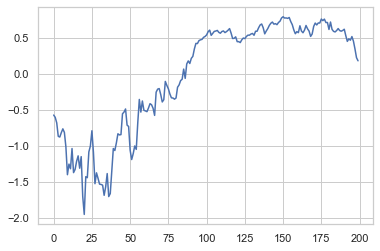

In [74]:
plt.plot(prob_tests_full_chain)

In [332]:
test_results['all_scores']

[0,
 0.039390405807004925,
 0.0416624254213287,
 0.03834324507976461,
 0.0373976761574033,
 0.039375472925358035,
 0.04186231292531273,
 0.03990780254825976,
 0.03929150585803898,
 0.04198884232595812,
 0.04211558210173871,
 0.04206204789300416,
 0.0401441655964182,
 0.040971399452054524,
 0.040303996211890625,
 0.04131559454757294,
 0.03934317149407651,
 0.03925710577644248,
 0.04175148588901023,
 0.041107299450953816,
 0.039292681470555646,
 0.03869766877252501,
 0.03885564774898731,
 0.03925714173300365,
 0.04073344838932624,
 0.038647522558910574,
 0.04071626785316662,
 0.03637032772929438,
 0.03972380160882927,
 0.03984321010318681,
 0.03961797920985699,
 0.039225806225561266,
 0.03896845284602979,
 0.040395237124434824,
 0.038799784356317035,
 0.041115008815419296,
 0.043479187694458465,
 0.03802746056369688,
 0.03889194802151974,
 0.038086171643626376,
 0.03892624149993551,
 0.03820620134952679,
 0.0366503400453666,
 0.041292719888326945,
 0.040242684338210544,
 0.04049438449851

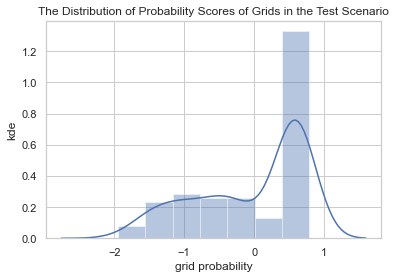

In [76]:
sns.distplot(prob_tests_full_chain)
plt.title(f"The Distribution of Probability Scores of Grids in the Test Scenario")
plt.ylabel('kde')
plt.xlabel('grid probability')
plt.show()

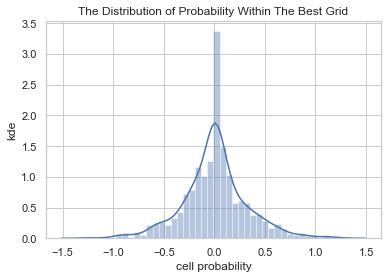

In [80]:
best_grid = full_test_chain[np.argmax(prob_tests_full_chain)]
flat_best_grid = tf.reshape(best_grid, [-1])
sns.distplot(flat_best_grid)
plt.title(f"The Distribution of Probability Within The Best Grid")
plt.ylabel('kde')
plt.xlabel('cell probability')
plt.show()

In [81]:
best_test_cell = np.unravel_index(np.argmax(flat_best_grid), best_grid.shape)
best_test_cell

(0, 5, 5)

In [83]:
best_grid[best_test_cell]

<tf.Tensor: shape=(), dtype=float32, numpy=1.2568718>

In [85]:
test_best_vote_pcts = tools.get_vote_pcts(best_test_cell, best_grid.shape[0], test_demo)
test_best_vote_pcts

{'Black': <tf.Tensor: shape=(), dtype=float32, numpy=0.05>,
 'white': <tf.Tensor: shape=(), dtype=float32, numpy=0.55>,
 'Latinx': <tf.Tensor: shape=(), dtype=float32, numpy=0.55>}

In [489]:
def test_prob_in_cell(index, grid):
    return grid[index]s

### Visualizations

In [763]:
def visualize_3d_grid(grid, demo):
    grid_indices = np.arange(grid.shape[0])
    test_x, test_y = np.meshgrid(grid_indices, grid_indices)
    test_z, _ = np.meshgrid(grid_indices, grid_indices)
    
    # Set 4th dimension
    color_dimension = test_prob_in_cell((test_x, test_y, test_z), grid)
    minn, maxx = color_dimension.min(), color_dimension.max()
    norm = matplotlib.colors.Normalize(minn, maxx)
    m = plt.cm.ScalarMappable(norm=norm, cmap='jet')
    m.set_array([])
    fcolors = m.to_rgba(color_dimension)
    
    fig = plt.figure(figsize=(9,6))
    ax = fig.gca(projection='3d')
    surface = ax.scatter(test_x, test_y, test_z, c=color_dimension.flatten(), cmap='Blues', marker="^")
    colorbar = fig.colorbar(surface, shrink=0.5, aspect=10)
    colorbar.ax.set_ylabel('probability')
    
    demo_groups = list(demo.keys())
    ax.set_xlabel(f"Group 1 voting index")
    ax.set_ylabel(f"Group 2 voting index")
    ax.set_zlabel(f"Group 3 voting index")
    ax.view_init(30, 30)
    plt.savefig("images/3d_viz.png")
    plt.draw()

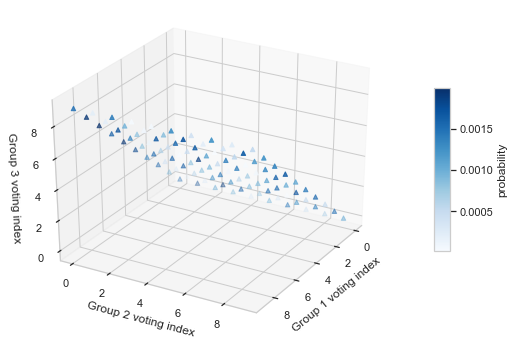

In [764]:
visualize_3d_grid(best_test_grid, test_demo)

In [394]:
test_grid_2d = make_grid(2, 10)
test_grid_2d

In [399]:
test_demo_2d = {'Black': 10, 'white': 8}

In [401]:
test_observed_2d = 7

In [408]:
test_results_2d = metropolis_hastings(100, test_grid_2d, test_observed_2d, test_demo_2d, scoring_type='prob', shift_type='uniform')

100%|██████████| 100/100 [00:01<00:00, 89.05it/s]


In [409]:
best_test_grid_2d = test_results_2d['best_grid']
best_test_grid_2d

array([[0.00176962, 0.00910411, 0.02132534, 0.00214673, 0.00491531,
        0.012186  , 0.02073707, 0.01119636, 0.02095889, 0.01324058],
       [0.00329417, 0.00058042, 0.01362255, 0.0023578 , 0.00147291,
        0.01269156, 0.0091377 , 0.02006492, 0.01791254, 0.01429386],
       [0.01912061, 0.01026564, 0.01557404, 0.00569451, 0.01558552,
        0.00726434, 0.01770231, 0.00057354, 0.0153244 , 0.02082664],
       [0.00577659, 0.01137331, 0.00640838, 0.01504918, 0.00538441,
        0.01158851, 0.00484246, 0.01298194, 0.02144744, 0.00151948],
       [0.00102396, 0.00484175, 0.00921055, 0.00703574, 0.00475795,
        0.01857046, 0.01877479, 0.00300041, 0.00803302, 0.00315371],
       [0.00240585, 0.00794914, 0.00662417, 0.01982493, 0.01927581,
        0.01151715, 0.01072349, 0.01175905, 0.00062662, 0.00477404],
       [0.00293423, 0.00330468, 0.01765157, 0.00203679, 0.00927572,
        0.00705075, 0.00108351, 0.01032535, 0.00831389, 0.00669071],
       [0.01452446, 0.02005106, 0.0044732

In [605]:
def get_most_probable_cell(grid):
    """
    Find the most probable cell in a grid.
    
    grid (NumPy array): the probabilistic grid
    
    return: the index of the most probable cell
    """
    return np.unravel_index(np.argmax(grid.flatten()), grid.shape)

In [606]:
best_test_cell_2d = get_most_probable_cell(best_test_grid_2d)
best_test_cell_2d

(8, 8)

In [761]:
def visualize_2d_grid(grid, demo):
    grid_indices = np.arange(grid.shape[0])
    test_x, test_y = np.meshgrid(grid_indices, grid_indices)
    
    fig = plt.figure(figsize=(9,6))
    ax = fig.gca(projection='3d')
    surface = ax.plot_surface(test_x, test_y, test_prob_in_cell((test_x, test_y), grid), rstride=1, cstride=1, edgecolor='none', cmap='Blues')
    colorbar = fig.colorbar(surface, shrink=0.5, aspect=10)
    colorbar.ax.set_ylabel('probability')
    
    demo_groups = list(demo.keys())
    ax.set_xlabel(f"Group 1 voting index")
    ax.set_ylabel(f"Group 2 voting index")
    plt.savefig("images/2d_viz.png")
    plt.show()

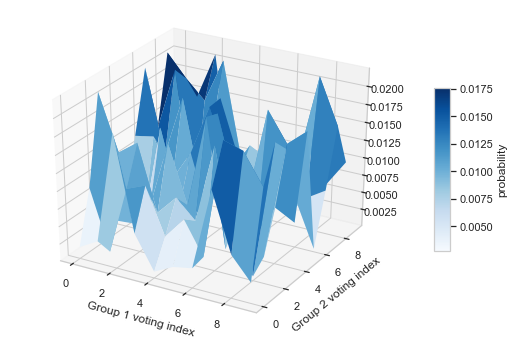

In [762]:
visualize_2d_grid(best_test_grid_2d, test_demo_2d)

### `generate_random_election`

Generate a random election.

In [525]:
def generate_random_election(candidates, demo, beta):
    """
    Generate a random election.
    
    candidates (string list): the candidates
    demo (dict): the demographics of the electorate
    beta (dict): the theoretical voting percentages of
    each demographic group, for each candidate
    
    return: a dictionary of candidates and the vote breakdowns by
    demographic group
    """
    # Set up the result dictionary
    num_groups = len(demo)
    result = {'a': (0, [0] * num_groups), 
              'b': (0, [0] * num_groups), 
              'c': (0, [0] * num_groups)}
    
    # Iterate through each demographic group
    for group_index, group in enumerate(demo):
        # Simulate each voter
        for voter in range(demo[group]):
            vote = np.random.choice(candidates, 1, beta[group])[0]
            prev_total, prev_breakdown = result[vote]
            prev_breakdown[group_index] += 1
            result[vote] = prev_total + 1, prev_breakdown
    return result

In [526]:
test_candidates = ['a', 'b', 'c']
test_beta = {'Black': [0.4, 0.5, 0.1], 
             'white': [0.3, 0.2, 0.5], 
             'Latinx': [0.3, 0.5, 0.2]}

In [527]:
test_random_election = generate_random_election(test_candidates, test_demo, test_beta)

In [625]:
test_random_election

{'a': (11, [6, 4, 1]), 'b': (7, [0, 4, 3]), 'c': (5, [4, 0, 1])}

In [529]:
test_observed_from_elec = 0
for candidate in test_random_election:
    test_observed_from_elec += test_random_election[candidate][0]
test_observed_from_elec

23

In [734]:
test_demo

{'Black': 10, 'white': 8, 'Latinx': 5}

In [653]:
test_results_with_elec = metropolis_hastings(500, test_grid, 11, test_demo, scoring_type='prob')

100%|██████████| 500/500 [07:55<00:00,  1.10it/s]


In [634]:
test_results_with_elec.keys()

dict_keys(['rejection_rate', 'best_grid', 'best_score', 'all_grids', 'all_scores'])

In [635]:
test_results_with_elec['best_grid']

array([[[1.23400090e-03, 8.17834594e-05, 1.42594118e-03, 1.83405554e-03,
         1.52228129e-03, 4.37034667e-04, 1.59317150e-03, 2.77217175e-04,
         1.85434960e-03, 6.36701874e-04],
        [9.46971860e-04, 1.61397345e-03, 1.87260187e-03, 1.22201198e-03,
         1.93788166e-03, 1.92036838e-03, 1.04814993e-03, 1.12839762e-03,
         6.57595161e-05, 1.42331045e-04],
        [8.23472905e-04, 2.56059983e-04, 3.74004388e-04, 2.35769555e-04,
         7.31698241e-04, 1.70912275e-03, 1.12776337e-03, 1.57717833e-03,
         3.17645584e-04, 1.28567437e-03],
        [4.82558386e-04, 1.18786406e-03, 9.63742210e-04, 1.18223209e-03,
         1.11241939e-03, 9.73568221e-04, 1.00184832e-03, 1.47167804e-03,
         1.90368493e-03, 7.68471335e-04],
        [1.63319729e-03, 6.43730483e-04, 6.65862118e-04, 8.41666637e-04,
         1.81213857e-03, 1.23699015e-03, 1.24977111e-03, 1.42919403e-03,
         8.46131638e-05, 1.52508614e-03],
        [5.56791944e-06, 1.50754026e-04, 1.62352567e-03, 2.5

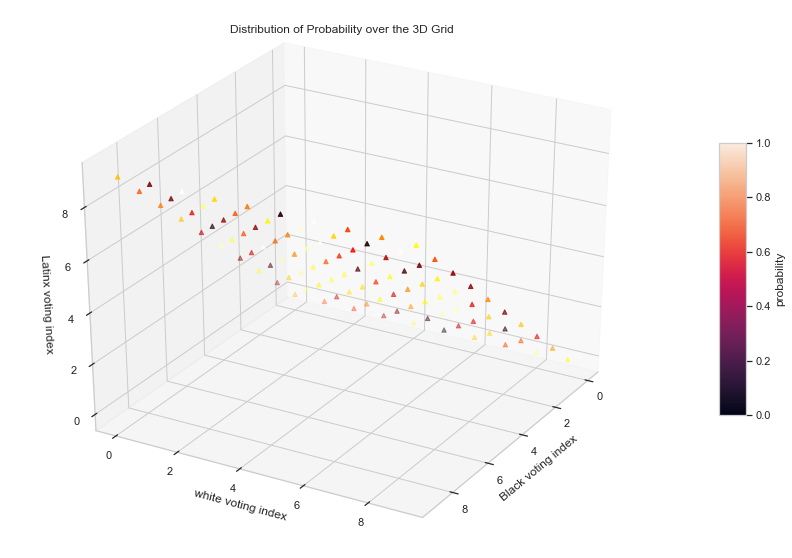

In [636]:
visualize_3d_grid(test_results_with_elec['best_grid'], test_demo)

In [649]:
temp1 = get_most_probable_cell(test_results_with_elec['best_grid'])

In [650]:
temp2 = test_prob_in_cell(temp1, test_results_with_elec['best_grid'])

In [651]:
get_vote_pcts(temp1, 10, test_demo)

{'Black': 0.85, 'white': 0.85, 'Latinx': 0.95}

### King's Ecological Inference

Reference: https://gist.github.com/ColCarroll/9fb0e6714dc0369acf6549cededcc875

In [698]:
def ei_two_by_two(demo_pcts, candidate_pcts, precint_populations, lmbda=0.5):
    """
    Run King's Ecological Inference method on
    a 2x2 example (2 demographic groups).
    
    group_demo_pcts (NumPy array): the percentage of people in the
    demographic group for each precinct
    group_voting_pcts (NumPy array): the percentage of people in the
    precinct who voted for a candidate
    precint_populations (NumPy array): the populations of the
    precincts
    lmbda (float): 
    
    return: the probabilistic model
    """
    demo_counts = candidate_pcts * precint_populations
    # Number of populations
    p = len(precint_populations) 
    with pm.Model() as model:   
        c_1 = pm.Exponential('c_1', lmbda)
        d_1 = pm.Exponential('d_1', lmbda)
        c_2 = pm.Exponential('c_2', lmbda)
        d_2 = pm.Exponential('d_2', lmbda)
        
        b_1 = pm.Beta('b_1', alpha=c_1, beta=d_1, shape=p)
        b_2 = pm.Beta('b_2', alpha=c_2, beta=d_2, shape=p)
    
        theta = demo_pcts * b_1 + (1 - demo_pcts) * b_2
        Tprime = pm.Binomial('Tprime', n=precint_populations , p=theta, observed=demo_counts)       
    return model

In [572]:
# Model four districts
group_demo_pcts = np.array([.1, .2, .3, .4])
group_voting_pcts = np.array([.11, .18, .34, .4])
precint_populations = np.array([100, 100, 100, 100])

In [709]:
toy_model = ei_two_by_two(group_demo_pcts, group_voting_pcts, precint_populations)

with toy_model:
    toy_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, d_2, c_2, d_1, c_1]
Sampling 4 chains, 181 divergences: 100%|██████████| 4000/4000 [00:14<00:00, 282.73draws/s]
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.911242061536291, but should be close to 0.8. Try to increase the number of tuning steps.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9168624001420249, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The e

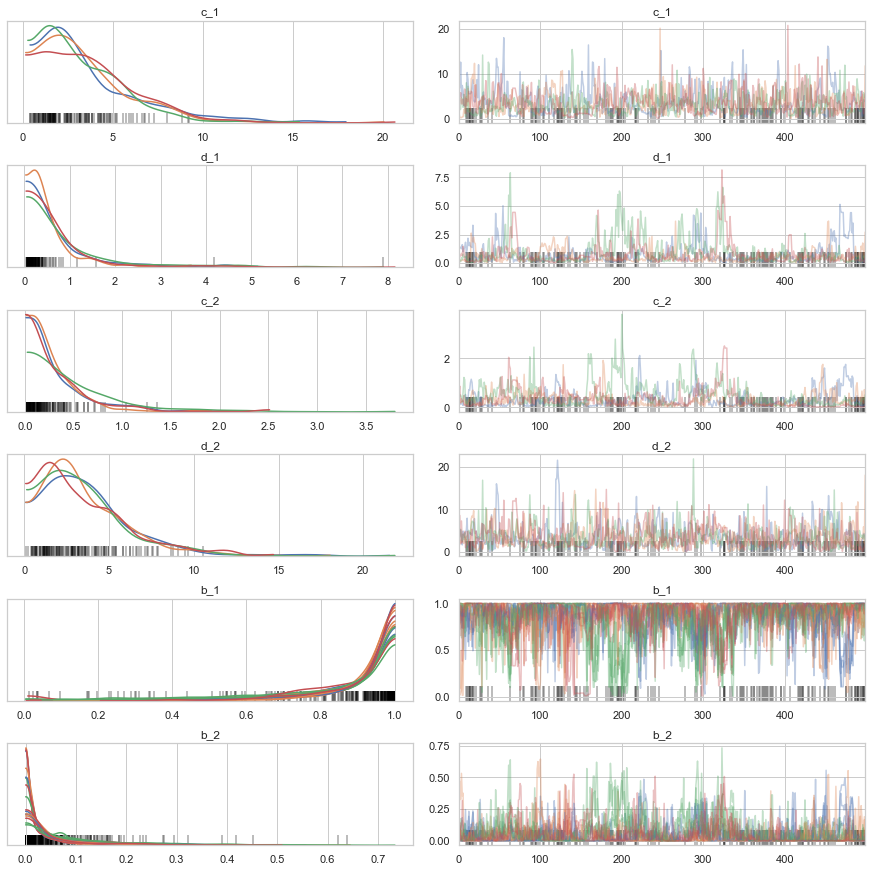

In [574]:
# Plot the traces
pm.traceplot(toy_trace);

In [568]:
print(f"b_1 mean across districts: {str(toy_trace.get_values('b_1').mean())}")

pm.stats.summary(toy_trace, var_names=['b_1', 'b_2'])

b_1 mean across districts: 0.4735644666633547


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b_1[0],0.475,0.351,0.0,0.993,0.016,0.012,463.0,463.0,299.0,198.0,1.02
b_1[1],0.470,0.350,0.0,0.994,0.015,0.011,513.0,513.0,379.0,299.0,1.01
b_1[2],0.479,0.354,0.0,0.995,0.017,0.012,459.0,459.0,284.0,171.0,1.03
b_1[3],0.471,0.351,0.0,0.994,0.016,0.011,470.0,470.0,344.0,355.0,1.02
b_2[0],0.491,0.348,0.0,0.994,0.018,0.012,393.0,393.0,313.0,206.0,1.01
b_2[1],0.473,0.349,0.0,0.996,0.018,0.013,359.0,359.0,258.0,210.0,1.01
b_2[2],0.489,0.348,0.0,0.995,0.018,0.013,356.0,356.0,272.0,133.0,1.01
b_2[3],0.491,0.355,0.0,0.996,0.020,0.014,331.0,331.0,249.0,176.0,1.02


In [597]:
# Run on a 40% Black, 60% white precinct
ei_test_demo = np.array([.4])
ei_test_candidate_vote = np.array([.5])
ei_precinct_population = np.array([10])

In [665]:
test_trace

<MultiTrace: 4 chains, 500 iterations, 12 variables>

In [598]:
test_model = ei_two_by_two(ei_test_demo, ei_test_candidate_vote, ei_precinct_population)

with test_model:
    test_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, d_2, c_2, d_1, c_1]
Sampling 4 chains, 47 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1036.20draws/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7130197299931359, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8793533255640547, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


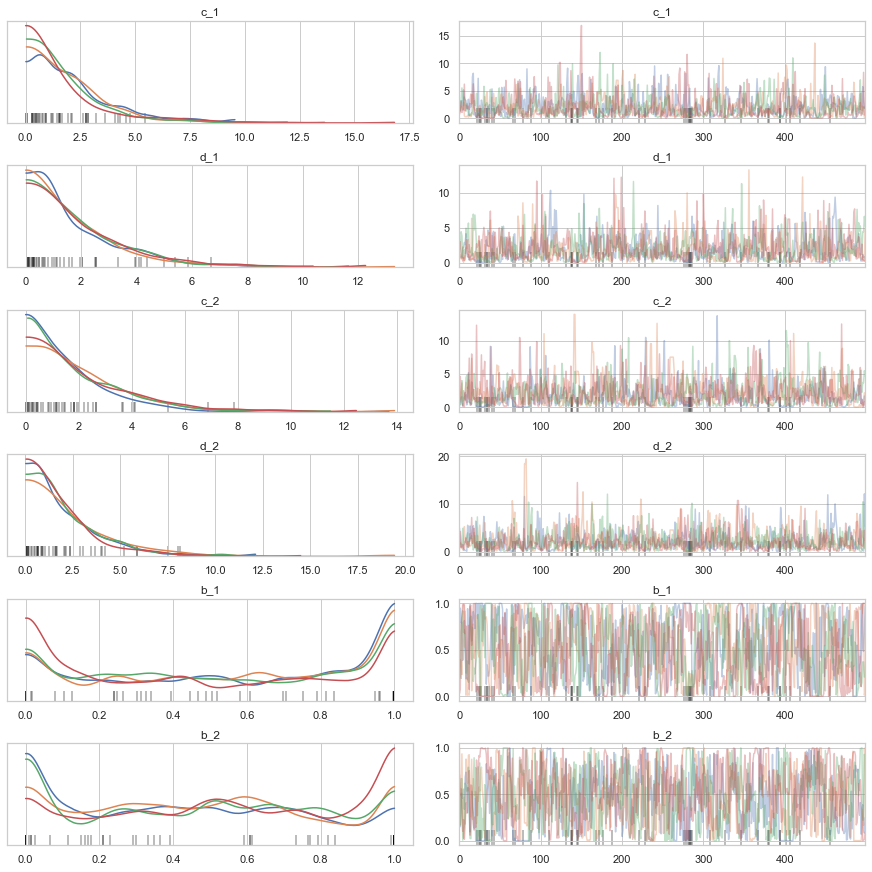

In [599]:
# Plot the traces
pm.traceplot(test_trace);

In [600]:
print(f"b_1 mean across districts: {str(toy_trace.get_values('b_1').mean())}")

pm.stats.summary(toy_trace, var_names=['b_1', 'b_2'])

b_1 mean across districts: 0.8680211702772286


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b_1[0],0.845,0.218,0.377,1.000,0.018,0.013,147.0,147.0,158.0,227.0,1.01
b_1[1],0.848,0.190,0.461,1.000,0.015,0.011,156.0,156.0,169.0,237.0,1.01
b_1[2],0.885,0.185,0.496,1.000,0.015,0.011,144.0,135.0,148.0,352.0,1.01
b_1[3],0.894,0.157,0.593,1.000,0.014,0.010,130.0,127.0,136.0,276.0,1.02
b_2[0],0.024,0.034,0.000,0.090,0.003,0.002,138.0,138.0,57.0,73.0,1.06
b_2[1],0.027,0.046,0.000,0.121,0.004,0.003,128.0,128.0,63.0,236.0,1.05
b_2[2],0.071,0.096,0.000,0.272,0.009,0.006,117.0,117.0,80.0,172.0,1.04
b_2[3],0.061,0.106,0.000,0.259,0.009,0.007,130.0,130.0,56.0,56.0,1.07


### Comparison of EI to Discrete Voter Model

In [601]:
grid_vs_ei_demo = {"Black": 4, "white": 6}
grid_vs_ei_observed = 5

In [619]:
test_grid_vs_ei = metropolis_hastings(100, make_grid(2, 10), grid_vs_ei_observed, grid_vs_ei_demo, scoring_type='prob')

100%|██████████| 100/100 [00:00<00:00, 113.17it/s]


In [620]:
test_best_grid_vs_ei = test_grid_vs_ei["best_grid"]

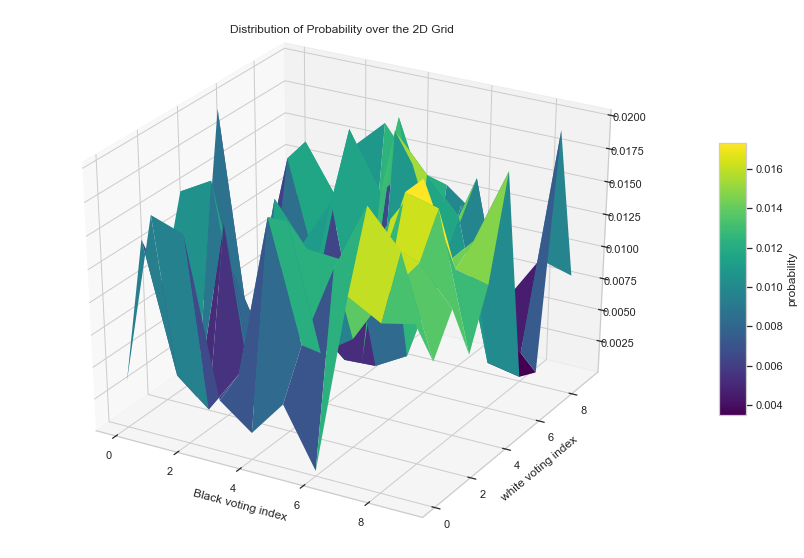

In [621]:
visualize_2d_grid(test_grid_vs_ei["best_grid"], grid_vs_ei_demo)

### Evaluation

In [675]:
def mse(a, b):
    """
    Find the mean squared error between
    two one-dimensional NumPy arrays.
    
    a (NumPy array-like): the first array
    b (NumPy array-like): the second array
    
    return: a float of the MSE
    """
    return np.mean((a - b) ** 2)

In [657]:
eval_candidates_2 = ['a', 'b']

In [655]:
# 2D evaluation
eval_demo_1 = {'Group 1': 50, 'Group 2': 50}
eval_demo_2 = {'Group 1': 25, 'Group 2': 75}
eval_demo_3 = {'Group 1': 10, 'Group 2': 90}

In [658]:
eval_beta_1 = {'Group 1': [0.5, 0.5], 
               'Group 2': [0.3, 0.7]}
eval_beta_2 = {'Group 1': [0.25, 0.75], 
               'Group 2': [0.2, 0.8]}

In [726]:
experiments_2d = []
random_election_1_1 = generate_random_election(eval_candidates, eval_demo_1, eval_beta_1)
experiments_2d.append((random_election_1_1, eval_demo_1, eval_beta_1, "1_1"))

random_election_1_2 = generate_random_election(eval_candidates, eval_demo_1, eval_beta_2)
experiments_2d.append((random_election_1_2, eval_demo_1, eval_beta_2, "1_2"))

random_election_2_1 = generate_random_election(eval_candidates, eval_demo_2, eval_beta_1)
experiments_2d.append((random_election_2_1, eval_demo_1, eval_beta_2, "2_1"))

random_election_2_2 = generate_random_election(eval_candidates, eval_demo_2, eval_beta_2)
experiments_2d.append((random_election_2_2, eval_demo_2, eval_beta_2, "2_2"))

random_election_3_1 = generate_random_election(eval_candidates, eval_demo_3, eval_beta_1)
experiments_2d.append((random_election_1_1, eval_demo_3, eval_beta_1, "3_1"))

random_election_3_2 = generate_random_election(eval_candidates, eval_demo_3, eval_beta_2)
experiments_2d.append((random_election_3_2, eval_demo_3, eval_beta_2, "3_2"))

In [727]:
experiments_2d

[({'a': (46, [24, 22]), 'b': (54, [26, 28]), 'c': (0, [0, 0])},
  {'Group 1': 50, 'Group 2': 50},
  {'Group 1': [0.5, 0.5], 'Group 2': [0.3, 0.7]},
  '1_1'),
 ({'a': (52, [26, 26]), 'b': (48, [24, 24]), 'c': (0, [0, 0])},
  {'Group 1': 50, 'Group 2': 50},
  {'Group 1': [0.25, 0.75], 'Group 2': [0.2, 0.8]},
  '1_2'),
 ({'a': (33, [6, 27]), 'b': (67, [19, 48]), 'c': (0, [0, 0])},
  {'Group 1': 50, 'Group 2': 50},
  {'Group 1': [0.25, 0.75], 'Group 2': [0.2, 0.8]},
  '2_1'),
 ({'a': (46, [13, 33]), 'b': (54, [12, 42]), 'c': (0, [0, 0])},
  {'Group 1': 25, 'Group 2': 75},
  {'Group 1': [0.25, 0.75], 'Group 2': [0.2, 0.8]},
  '2_2'),
 ({'a': (46, [24, 22]), 'b': (54, [26, 28]), 'c': (0, [0, 0])},
  {'Group 1': 10, 'Group 2': 90},
  {'Group 1': [0.5, 0.5], 'Group 2': [0.3, 0.7]},
  '3_1'),
 ({'a': (42, [5, 37]), 'b': (58, [5, 53]), 'c': (0, [0, 0])},
  {'Group 1': 10, 'Group 2': 90},
  {'Group 1': [0.25, 0.75], 'Group 2': [0.2, 0.8]},
  '3_2')]

In [754]:
def dvm_king_evaluator(election, demo, beta, label, n_iter=1):
    """
    Run and compare the results of the Discrete
    Voter Model and King's EI on generated
    election data.
    
    election (dict): the random election to
    evaluate on
    demo (dict): the demographic dictionary of
    a precinct
    n_iter (int): the number of times to repeat
    the experiment
    label (string): the label of the experiment
    
    return: a dictionary of the label and times and MSEs for
    the Discrete Voter Model and King's EI
    """
    results = {}
    dvm_total_time = 0
    dvm_total_mse = 0

    king_total_time = 0
    king_total_mse = 0

    temp_pcts_array = [pcts[0] for group, pcts in beta.items()]
    true_pcts = np.fromiter(temp_pcts_array, dtype=float)

    for _ in range(n_iter):
        # Get the observed votes for candidate a
        candidate_a_obs = random_election_1_1['a'][0]

        # Run Metropolis-Hastings and time it
        met_iter = 100 if len(demo) > 2 else 200
        dvm_total_time -= time.time()
        initial_grid = make_grid(len(demo), 10)
        met_result = metropolis_hastings(met_iter, initial_grid, candidate_a_obs, demo, scoring_type='prob')
        dvm_total_time += time.time()

        # Find the best grid and output the result
        best_grid = met_result['best_grid']
        best_cell = get_most_probable_cell(met_result['best_grid'])
        vote_pcts = get_vote_pcts(best_cell, 10, demo)

        # Find the MSE of the result
        dvm_mse_array = np.fromiter(vote_pcts.values(), dtype=float)
        dvm_total_mse += mse(dvm_mse_array, true_pcts)

        # Run King's EI and time it, if at the right dimension
        if len(demo) > 2:
            continue
        king_demo = list(demo.values())[0] / 100
        king_cand_vote = candidate_a_obs / 100
        king_prec_pop = np.array([100])

        king_total_time -= time.time()
        king_model = ei_two_by_two(king_demo, king_cand_vote, king_prec_pop)
        with king_model:
            king_trace = pm.sample()
        king_total_time += time.time()

        # Find the MSE of the result
        king_mse_array = np.fromiter([king_trace.get_values('b_1').mean(), 
                                      king_trace.get_values('b_2').mean()], 
                                     dtype=float)

        king_total_mse += mse(king_mse_array, true_pcts)


    return {'label': label,
            'dvm_time': dvm_total_time / n_iter, 
            'dvm_mse': dvm_total_mse / n_iter, 
            'king_time': king_total_time / n_iter, 
            'king_mse': king_total_mse / n_iter}

In [723]:
dvm_king_evaluator(random_election_1_1, eval_demo_1, eval_beta_1, "1_1")

met-hastings: 100%|██████████| 200/200 [00:13<00:00, 14.37it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, d_2, c_2, d_1, c_1]
Sampling 4 chains, 163 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 381.07draws/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9012423977239461, but should be close to 0.8. Try to increase the number of tuning steps.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.555050636703833, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the tar

{'label': '1_1',
 'dvm_time': 13.523716926574707,
 'dvm_mse': 0.11249999999999999,
 'king_time': 16.205082178115845,
 'king_mse': 0.01486711729172573}

In [662]:
# 3D evaluation
eval_demo_4 = {'Group 1': 50, 'Group 2': 50, 'Group 3': 0}
eval_demo_5 = {'Group 1': 25, 'Group 2': 25, 'Group 3': 50}
eval_demo_6 = {'Group 1': 33, 'Group 2': 33, 'Group 3': 34}

In [663]:
eval_beta_3 = {'Group 1': [0.2, 0.8], 
               'Group 2': [0.8, 0.2], 
               'Group 3': [0.4, 0.6]}
eval_beta_4 = {'Group 1': [0.3, 0.7], 
               'Group 2': [0.4, 0.6], 
               'Group 3': [0.5, 0.5]}

In [730]:
experiments_3d = []
random_election_4_3 = generate_random_election(eval_candidates, eval_demo_4, eval_beta_3)
experiments_3d.append((random_election_4_3, eval_demo_4, eval_beta_3, "4_3"))

random_election_4_4 = generate_random_election(eval_candidates, eval_demo_4, eval_beta_4)
experiments_3d.append((random_election_4_4, eval_demo_4, eval_beta_4, "4_4"))

random_election_5_3 = generate_random_election(eval_candidates, eval_demo_5, eval_beta_3)
experiments_3d.append((random_election_5_3, eval_demo_5, eval_beta_3, "5_3"))

random_election_5_4 = generate_random_election(eval_candidates, eval_demo_5, eval_beta_4)
experiments_3d.append((random_election_5_4, eval_demo_5, eval_beta_4, "5_4"))

random_election_6_3 = generate_random_election(eval_candidates, eval_demo_6, eval_beta_3)
experiments_3d.append((random_election_6_3, eval_demo_6, eval_beta_3, "6_3"))

random_election_6_4 = generate_random_election(eval_candidates, eval_demo_6, eval_beta_4)
experiments_3d.append((random_election_6_4, eval_demo_6, eval_beta_4, "6_4"))

In [743]:
dvm_king_evaluator(*experiments_3d[0])




met-hastings:   0%|          | 0/50 [00:00<?, ?it/s]


met-hastings:   2%|▏         | 1/50 [00:13<11:06, 13.61s/it]

KeyboardInterrupt: 

In [745]:
results_2d = [dvm_king_evaluator(*experiment, n_iter=5) for experiment in experiments_2d]





met-hastings:   0%|          | 0/50 [00:00<?, ?it/s]



met-hastings:   4%|▍         | 2/50 [00:00<00:03, 13.70it/s]



met-hastings:   8%|▊         | 4/50 [00:00<00:03, 13.59it/s]



met-hastings:  12%|█▏        | 6/50 [00:00<00:03, 14.26it/s]



met-hastings:  16%|█▌        | 8/50 [00:00<00:02, 14.13it/s]



met-hastings:  20%|██        | 10/50 [00:00<00:02, 14.51it/s]



met-hastings:  24%|██▍       | 12/50 [00:00<00:02, 14.71it/s]



met-hastings:  28%|██▊       | 14/50 [00:00<00:02, 15.26it/s]



met-hastings:  32%|███▏      | 16/50 [00:01<00:02, 15.30it/s]



met-hastings:  36%|███▌      | 18/50 [00:01<00:02, 15.31it/s]



met-hastings:  40%|████      | 20/50 [00:01<00:01, 15.37it/s]



met-hastings:  44%|████▍     | 22/50 [00:01<00:01, 15.28it/s]



met-hastings:  48%|████▊     | 24/50 [00:01<00:01, 15.20it/s]



met-hastings:  52%|█████▏    | 26/50 [00:01<00:01, 15.28it/s]



met-hastings:  56%|█████▌    | 28/50 [00:01<00:01, 15.57it/s]



met-hastings:  60%|██████    | 30/

In [766]:
pd.DataFrame(results_2d).to_csv("experiment_results/2d.csv", index=False)

In [755]:
results_3d = [dvm_king_evaluator(*experiment, n_iter=3) for experiment in experiments_3d]






met-hastings:   0%|          | 0/100 [00:00<?, ?it/s]




met-hastings:   1%|          | 1/100 [00:13<22:40, 13.74s/it]




met-hastings:   2%|▏         | 2/100 [00:28<22:48, 13.96s/it]




met-hastings:   3%|▎         | 3/100 [00:43<23:02, 14.25s/it]




met-hastings:   4%|▍         | 4/100 [00:57<22:54, 14.32s/it]




met-hastings:   5%|▌         | 5/100 [01:12<23:07, 14.61s/it]




met-hastings:   6%|▌         | 6/100 [01:27<22:43, 14.51s/it]




met-hastings:   7%|▋         | 7/100 [01:41<22:29, 14.51s/it]




met-hastings:   8%|▊         | 8/100 [01:55<21:57, 14.32s/it]




met-hastings:   9%|▉         | 9/100 [02:09<21:29, 14.18s/it]




met-hastings:  10%|█         | 10/100 [02:23<21:02, 14.03s/it]




met-hastings:  11%|█         | 11/100 [02:36<20:43, 13.98s/it]




met-hastings:  12%|█▏        | 12/100 [02:50<20:20, 13.87s/it]




met-hastings:  13%|█▎        | 13/100 [03:04<19:58, 13.78s/it]




met-hastings:  14%|█▍        | 14/100 [03:17<19:39, 13.71s/it]




met-hast

In [767]:
pd.DataFrame(results_3d).to_csv("experiment_results/3d.csv", index=False)